<a href="https://colab.research.google.com/github/basselkassem/addressing-hadron-collider-challenges-with-ML/blob/master/bayesian_opt_detector_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

We aim in this project to use machine learning methods to optimize the LHC detector structure in a way that maximizes its ability to detect the charactristics of the particles that fly through it.

This notebook includes:

1.  Problem description
2.  Detector simulation
3.  Random optimization of the detector
4.  Bayesian optimization of the detector
5.  Comparing results

# Problem desciption

A detector in LHC may consists of Crystal tubes. The Crystal tube  measures the charge (energy) of the particle when the particle hits this tube. The charge of the particle can be used to identify the type of this particle. Those Crystal tubes are expensive and it not always possible to obtain large number of them.
Due to the large number of particles produced after each collision in LHC, it is hard to find the optimal palcement of  of the Crystal tubes (geometric location) in the detector in away that maximizes the hits rate and thus the particales type classification.

We have a tracking detector consists of:
1.  4 layers of Crystal tubes
2.  Each layer consists of 200 tubes

The radius of each tube is 1cm. the distance between tubes in one layer(Pitch) is 4cm.  The detector is parametrized by six adjustable parameters:  𝑦1 ,  𝑦2 ,  𝑦3 ,  𝑧1 ,  𝑧2 ,  𝑧3 . One constraint is: z > 2 otherwise the tubes will collide with each other.


These parameters describe shifts between the layers as it is show in the figure:

![alt text](https://raw.githubusercontent.com/MohamedElashri/Hadron-Collider-ML/master/week5/pic/system.png)

# Download files

In [1]:
!wget !wget https://raw.githubusercontent.com/hse-aml/hadron-collider-machine-learning/master/week5/utils.py

--2020-12-08 09:52:01--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2020-12-08 09:52:01--  https://raw.githubusercontent.com/hse-aml/hadron-collider-machine-learning/master/week5/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6311 (6.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.16K  --.-KB/s    in 0s      

2020-12-08 09:52:02 (69.5 MB/s) - ‘utils.py’ saved [6311/6311]

FINISHED --2020-12-08 09:52:02--
Total wall clock time: 0.3s
Downloaded: 1 files, 6.2K in 0s (69.5 MB/s)


# Import Libs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import time
import random
import pandas as pd
import seaborn as sns
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from hyperopt.pyll import stochastic

# Detector Simulation

## Detector geometry generation

Detecor Layers Number: 4
Layer Tubes Number: 201


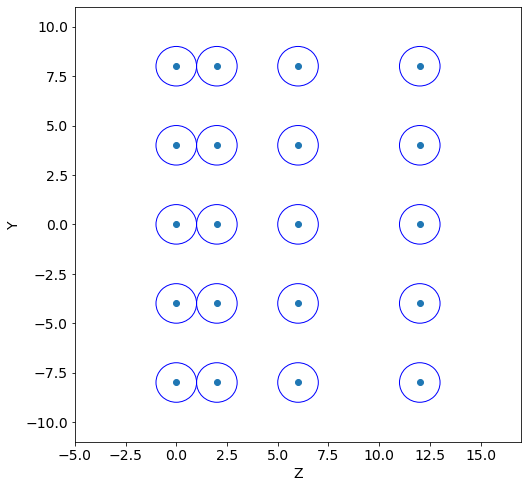

In [3]:
TUBE_RADIUS = 1. #cm
LAYERS_OFFSET = 4 #cm

y1, y2, y3 = 0, 0, 0
z1, z2, z3 = 2, 4, 6

tracker = utils.Tracker(TUBE_RADIUS, LAYERS_OFFSET, y1, y2, y3, z1, z2, z3)
Z, Y = tracker.create_geometry()

print('Detecor Layers Number:', Z.shape[1])
print('Layer Tubes Number:', Y.shape[0])
utils.geometry_display(Z, Y, TUBE_RADIUS, y_min=-10, y_max=10)

## Track generation
Lets generate several tracks of particles fly in the tracking system. We consider straight tracks with equation: 

$$
y = kz + b
$$

where $z, y$ are coordinates of the track, $k$ is slope of the track and $b$ is the y intercept.

Track parameters are generated from the following distributions:

$$
b \in U(b_{min}, b_{max})\\
k = tan(\alpha), \alpha \in N(\mu_{\alpha}, \sigma_{\alpha})
$$

where $U$ is uniform distribution and $N$ is normal distribution.

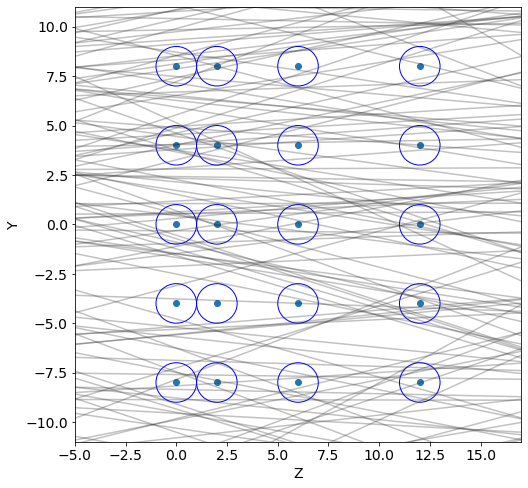

In [4]:
N_tracks = 1000
t = utils.Tracks(b_min=-100, b_max=100, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

utils.geometry_display(Z, Y, TUBE_RADIUS, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

## Target metrics
For a given geaometry of the tracking system we will calculate the ratio of tracks with at least 2 hits to the total number of tracks:

$$Score = \frac{N\_tracks_{n\_hits \ge 2}}{N\_tracks}$$

The higher score, the better.



In [5]:
score = utils.get_score(Z, Y, tracks, TUBE_RADIUS)
print(score)

0.648


# Globals

In [88]:
ITER_NUM = 500
TRACKS_NUM = 10**3
track_generator = utils.Tracks(b_min = -100, b_max = 100, alpha_mean=0, alpha_std=0.2)
TRACKS = track_generator.generate(TRACKS_NUM)
y1_min, y1_max = [0, 20]
y2_min, y2_max = [0, 20]
y3_min, y3_max = [0, 20]
z1_min, z1_max = [0, 20]
z2_min, z2_max = [0, 20]
z3_min, z3_max = [0, 20]
r_min, r_max = [TUBE_RADIUS - 10**-3, TUBE_RADIUS + 10**-3]
p_min, p_max = [LAYERS_OFFSET - 10**-3, LAYERS_OFFSET + 10**-3]

def extract_params(params):
  y1 = params['y1']
  y2 = params['y2']  
  y3 = params['y3']  
  z1 = params['z1']  
  z2 = params['z2']  
  z3 = params['z3']  
  raduis = params['radius']  
  pitch = params['pitch']
  return (y1, y2, y3, z1, z2, z3, raduis, pitch)

def sample_params(params_grid):
  return {key: random.sample(value, 1)[0] for key, value in params_grid.items()}

# Random Optimiztion

## Objective defintion

In [89]:
def random_objective(params, iter):
  start = time.time()
  y1, y2, y3, z1, z2, z3, r, p = extract_params(params)
  tracker = utils.Tracker(r, p, y1, y2, y3, z1, z2, z3)
  Z, Y = tracker.create_geometry()
  score = utils.get_score(Z, Y, TRACKS, r)
  loss = 1 - score
  end = time.time()
  return [loss, params, iter, end - start]

## Search space

In [90]:
params_grid = {
    'y1': list(np.linspace(y1_min, y1_max, num = 100)), 
    'y2': list(np.linspace(y2_min, y2_max, num = 100)), 
    'y3': list(np.linspace(y3_min, y3_max, num = 100)), 
    'z1': list(np.linspace(z1_min, z1_max, num = 100)), 
    'z2': list(np.linspace(z2_min, z2_max, num = 100)), 
    'z3': list(np.linspace(z3_min, z3_max, num = 100)),
    'radius': list(np.linspace(r_min, r_max, num = 100)), 
    'pitch': list(np.linspace(p_min, p_max, num = 100)),
}

sample = sample_params(params_grid)
sample

{'pitch': 4.000636363636364,
 'radius': 1.0008181818181816,
 'y1': 8.88888888888889,
 'y2': 14.545454545454545,
 'y3': 2.4242424242424243,
 'z1': 13.93939393939394,
 'z2': 13.737373737373737,
 'z3': 13.93939393939394}

## Objective optimization

In [91]:
%%time
rand_results_df = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'time'],
                               index = range(ITER_NUM))
for i in range(ITER_NUM):
  params = sample_params(params_grid)
  res = random_objective(params, i)
  rand_results_df.iloc[i, :] = res

CPU times: user 9.91 s, sys: 691 µs, total: 9.91 s
Wall time: 9.94 s


In [92]:
rand_results_df.sort_values(by = 'loss', ascending=True, inplace=True)
rand_results_df.reset_index(drop=True, inplace=True)
rand_results_df.head()

,loss,params,iteration,time
0,0.195,"{'y1': 6.666666666666667, 'y2': 15.75757575757...",206,0.0188332
1,0.197,"{'y1': 6.666666666666667, 'y2': 19.19191919191...",220,0.0188131
2,0.197,"{'y1': 11.717171717171716, 'y2': 17.7777777777...",473,0.0191221
3,0.202,"{'y1': 5.454545454545454, 'y2': 10.10101010101...",214,0.0191355
4,0.205,"{'y1': 17.77777777777778, 'y2': 14.94949494949...",152,0.0228684


## Evaluation

In [93]:
rand_params = rand_results_df.loc[0, 'params'].copy()
y1, y2, y3, z1, z2, z3, r, p = extract_params(rand_params)
tracker = utils.Tracker(r, p, y1, y2, y3, z1, z2, z3)
Z, Y = tracker.create_geometry()
score = utils.get_score(Z, Y, TRACKS, r)
print('Random search score:', score)
print('parameters:')
rand_params

Random search score: 0.805
parameters:


{'pitch': 4.000555555555556,
 'radius': 1.000050505050505,
 'y1': 6.666666666666667,
 'y2': 15.757575757575758,
 'y3': 5.454545454545454,
 'z1': 0.0,
 'z2': 17.575757575757574,
 'z3': 0.40404040404040403}

### Display optimal detector

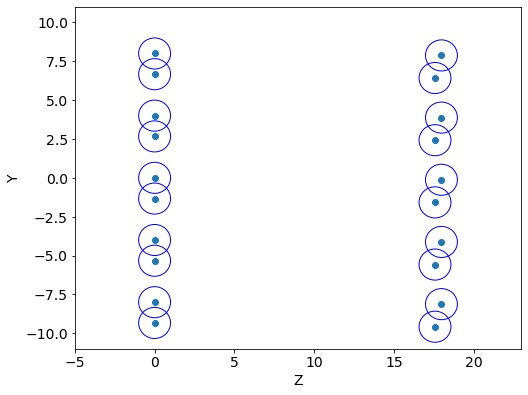

In [94]:
utils.geometry_display(Z, Y, r, y_min=-10, y_max=10)

# Bayesian Optimiztion

## Objective defintion

In [73]:
def objective(params):
  global iteration
  iteration += 1
  start = time.time()
  y1, y2, y3, z1, z2, z3, r, p = extract_params(params)
  tracker = utils.Tracker(r, p, y1, y2, y3, z1, z2, z3)
  Z, Y = tracker.create_geometry()
  score = utils.get_score(Z, Y, TRACKS, r)
  loss = 1 - score
  end = time.time()
  return {'loss': loss, 'status': STATUS_OK, 'params': params, 'iteration': iteration, 'time': end - start}

## Search space

In [74]:
space = {
         'y1': hp.uniform('y1', y1_min, y1_max), 
         'y2': hp.uniform('y2', y2_min, y2_max), 
         'y3': hp.uniform('y3', y3_min, y3_max), 
         'z1': hp.uniform('z1', z1_min, z1_max), 
         'z2': hp.uniform('z2', z2_min, z2_max), 
         'z3': hp.uniform('z3', z3_min, z3_max),
         'radius': hp.uniform('raduis', r_min, r_max), 
         'pitch': hp.uniform('pitch', p_min, p_max),
}
stochastic.sample(space)

{'pitch': 4.000340504942325,
 'radius': 0.9999095613292043,
 'y1': 10.833737693181197,
 'y2': 0.7029198851908037,
 'y3': 10.925229424210459,
 'z1': 0.8582710475188614,
 'z2': 10.74945354958829,
 'z3': 0.7777985112979608}

## Objective optimization

In [75]:
opt_algo = tpe.suggest
trials = Trials()

global iteration
iteration = 0
res = fmin(fn = objective, space = space, algo = opt_algo, max_evals = ITER_NUM, trials=trials)

100%|██████████| 500/500 [00:23<00:00, 21.33it/s, best loss: 0.0050000000000000044]


## Evaluation

In [76]:
bayes_results_df = pd.DataFrame.from_dict(trials.results)
bayes_results_df.sort_values(by = 'loss', ascending=True, inplace=True)
bayes_results_df.reset_index(drop = True, inplace = True)
bayes_results_df.drop(columns='status', inplace=True)
bayes_results_df.head()

,loss,params,iteration,time
0,0.005,"{'pitch': 4.000558386127232, 'radius': 1.00006...",458,0.018816
1,0.007,"{'pitch': 4.00062342949231, 'radius': 1.000155...",423,0.022763
2,0.007,"{'pitch': 4.000732097309122, 'radius': 0.99995...",418,0.019240
3,0.007,"{'pitch': 4.000721268674713, 'radius': 1.00036...",447,0.018598
4,0.007,"{'pitch': 4.000901798624728, 'radius': 1.00027...",428,0.019071


In [77]:
bayes_params = bayes_results_df.loc[0, 'params'].copy()
y1, y2, y3, z1, z2, z3, r, p = extract_params(bayes_params)
tracker = utils.Tracker(r, p, y1, y2, y3, z1, z2, z3)
Z, Y = tracker.create_geometry()
score = utils.get_score(Z, Y, TRACKS, r)
print('bayesian search score:', score)
print('parameters:')
bayes_params

bayesian search score: 0.995
parameters:


{'pitch': 4.000558386127232,
 'radius': 1.0000675014140294,
 'y1': 9.986615329172302,
 'y2': 0.14949379229492904,
 'y3': 10.002450905896808,
 'z1': 0.15884613711530027,
 'z2': 10.779088945632623,
 'z3': 0.22117622721079053}

### Display optimal detector

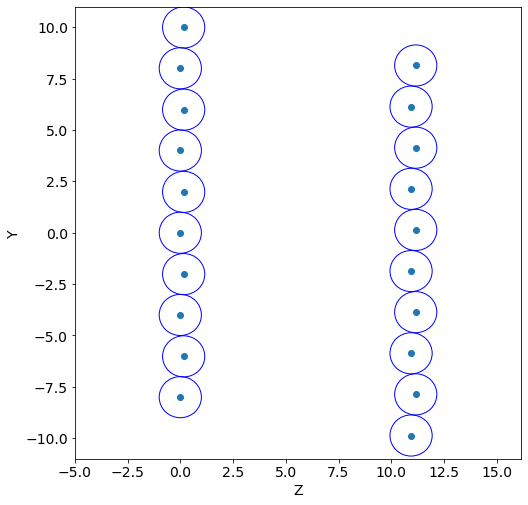

In [78]:
utils.geometry_display(Z, Y, r, y_min=-10, y_max=10)

# Compare Results

In [95]:
rand_results_df['method'] = 'random search'
bayes_results_df['method'] = 'Bayesian Optimiztion'
best_params_df = pd.DataFrame(rand_results_df, index=[0]).append(
    pd.DataFrame(bayes_results_df, index = [0]), ignore_index = True, sort = True
)
best_params_df

,iteration,loss,method,params,time
0,206,0.195,random search,"{'y1': 6.666666666666667, 'y2': 15.75757575757...",0.0188332
1,458,0.005,Bayesian Optimiztion,"{'pitch': 4.000558386127232, 'radius': 1.00006...",0.0188155


In [96]:
def create_param_df(df):
  df_params = pd.DataFrame(columns = list(df.loc[0, 'params'].keys()),
                            index = list(range(len(df))))

  for i, params in enumerate(df['params']):
      df_params.loc[i, :] = list(params.values())
      
  df_params['loss'] = df['loss']
  df_params['iteration'] = df['iteration']

  return df_params

bayes_params_df = create_param_df(bayes_results_df)
random_params_df = create_param_df(rand_results_df)

y1


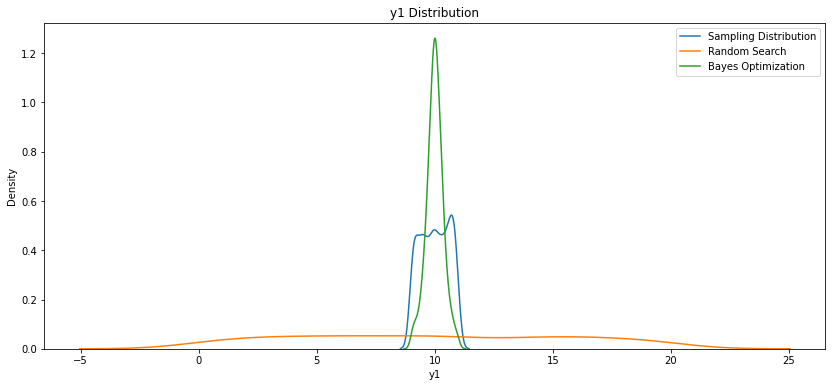

y2


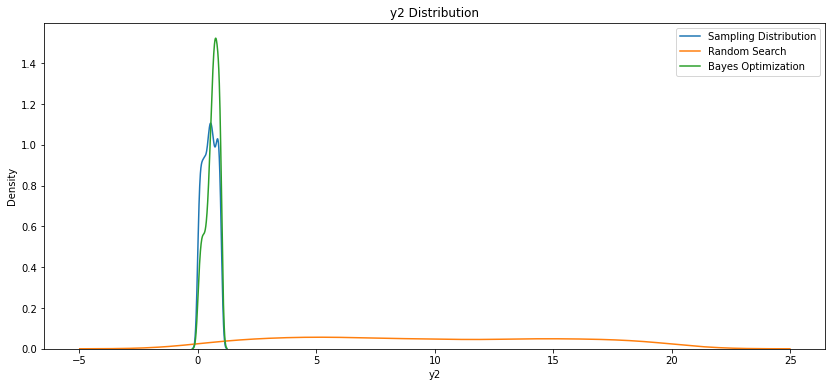

y3


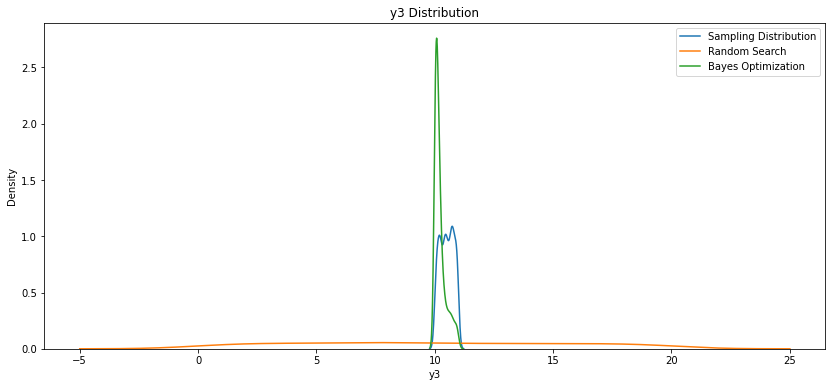

z1


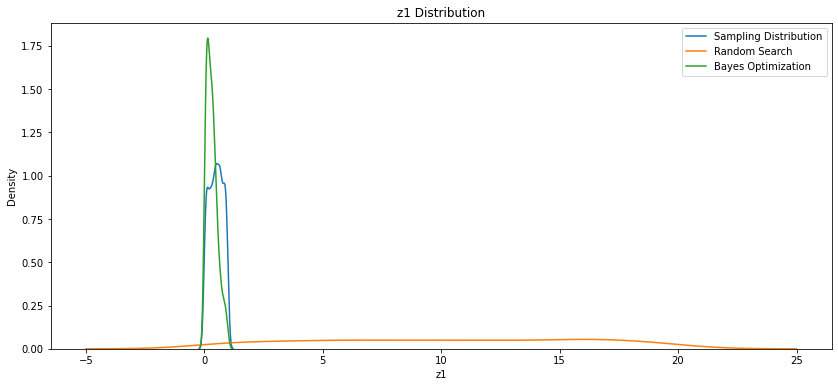

z2


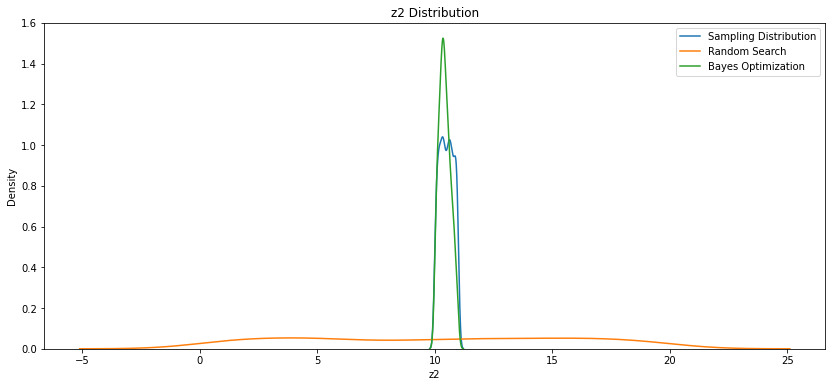

z3


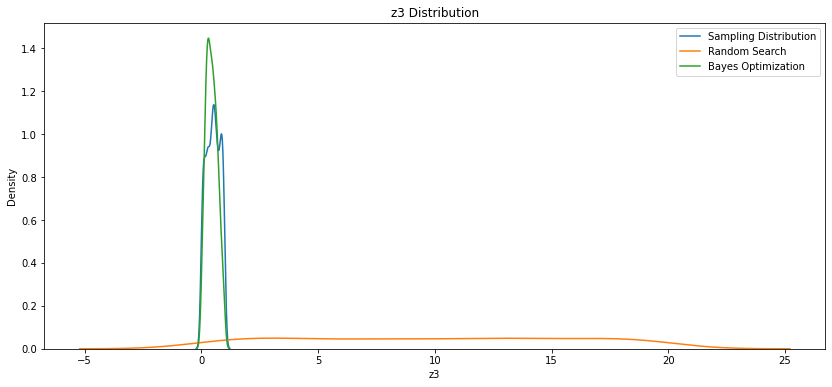

radius


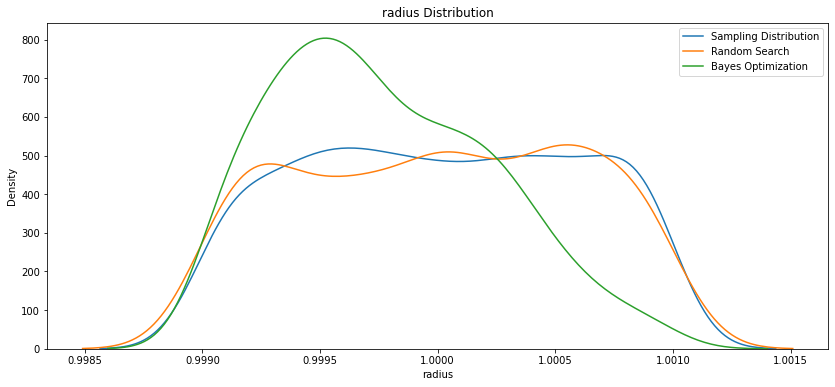

pitch


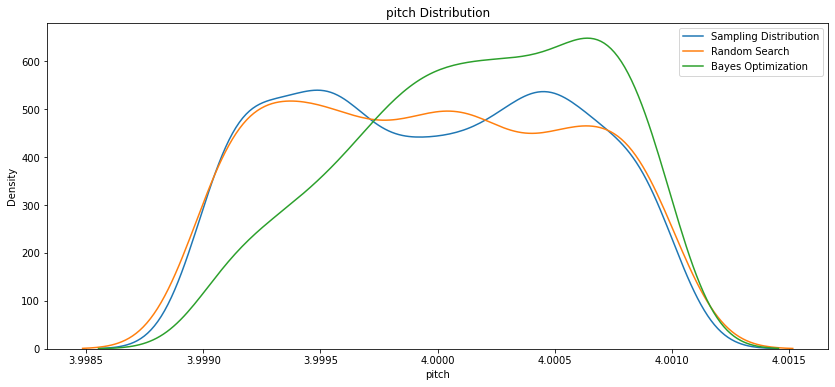

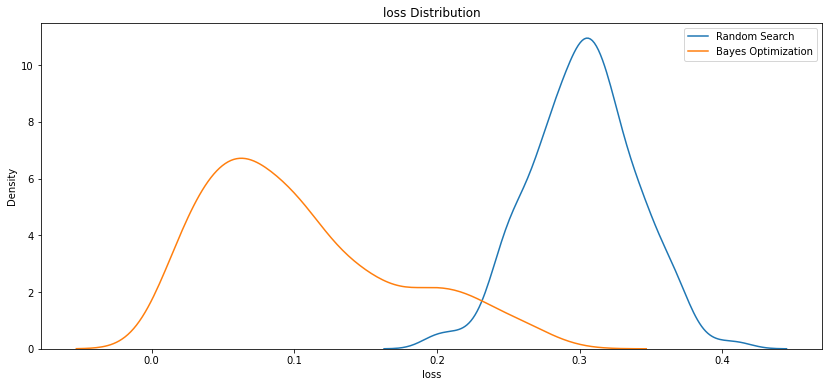

In [97]:
for i, hyper in enumerate(random_params_df.columns):
  if hyper not in ['iteration']:
    plt.figure(figsize = (14, 6))
    if hyper != 'loss':
      print(hyper)
      sns.kdeplot([stochastic.sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
    sns.kdeplot(list(random_params_df[hyper].values), label = 'Random Search')
    sns.kdeplot(list(bayes_params_df[hyper].values), label = 'Bayes Optimization')
    plt.legend(loc = 1)
    plt.title('{} Distribution'.format(hyper))
    plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
    plt.show();

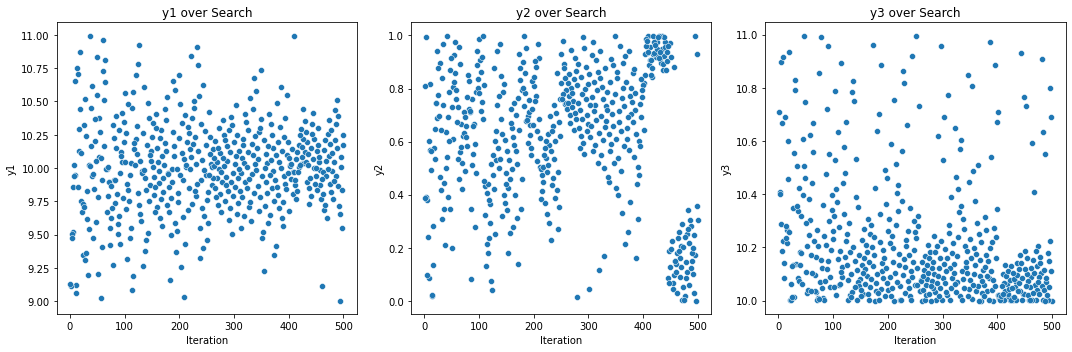

In [98]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
i = 0
for i, hyper in enumerate(['y1', 'y2', 'y3']):
  sns.scatterplot(x = 'iteration', y =  hyper, data = bayes_params_df, ax = axs[i])
  axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));
plt.tight_layout()

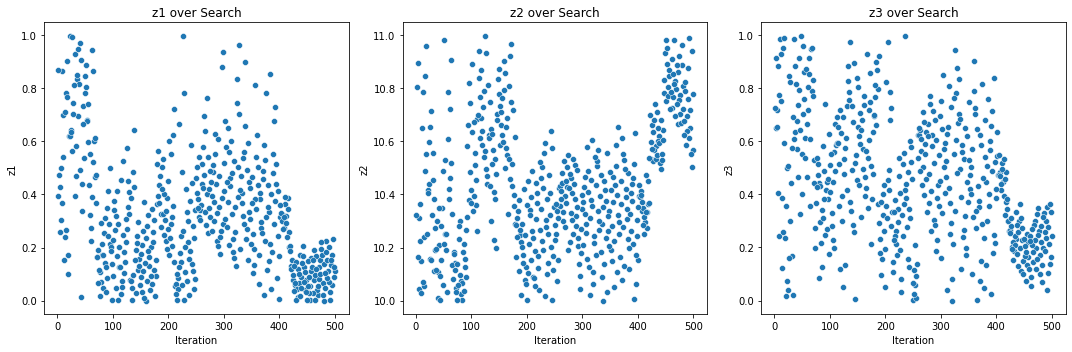

In [99]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
i = 0
for i, hyper in enumerate(['z1', 'z2', 'z3']):
        sns.scatterplot(x = 'iteration', y=  hyper, data = bayes_params_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));
plt.tight_layout()

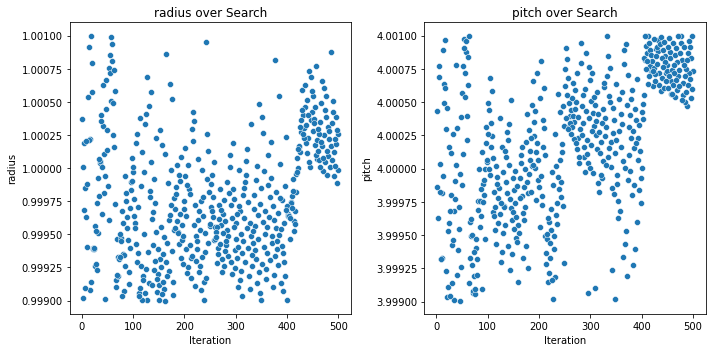

In [100]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
i = 0
for i, hyper in enumerate(['radius', 'pitch']):
  sns.scatterplot(x = 'iteration', y =  hyper, data = bayes_params_df, ax = axs[i])
  axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));
plt.tight_layout()

In [101]:
scores = pd.DataFrame({'score': 1 - random_params_df['loss'], 'iteration': random_params_df['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'score': 1 - bayes_params_df['loss'], 'iteration': bayes_params_df['iteration'], 'search': 'Bayes'}))

scores['score'] = scores['score'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,score,iteration,search
0,0.805,206,random
1,0.803,220,random
2,0.803,473,random
3,0.798,214,random
4,0.795,152,random


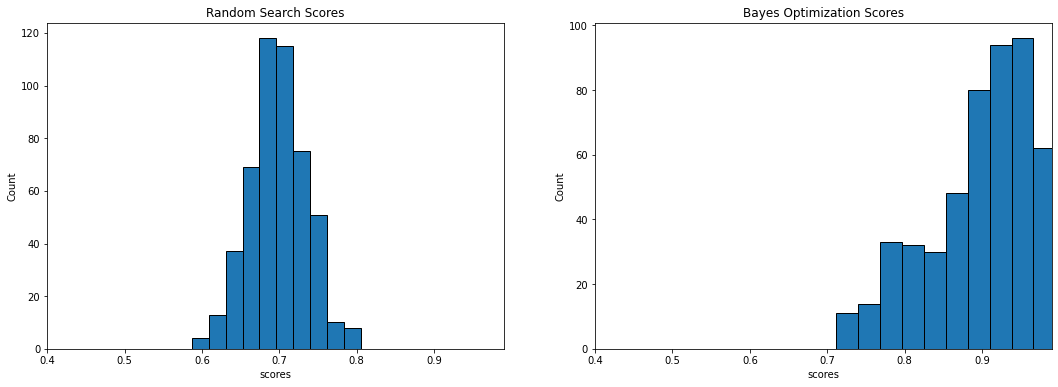

In [102]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - rand_results_df['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("scores"); plt.ylabel("Count"); plt.title("Random Search Scores")
plt.xlim(0.4, 0.99)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params_df['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("scores"); plt.ylabel("Count"); plt.title("Bayes Optimization Scores");
plt.xlim(0.4, 0.99);

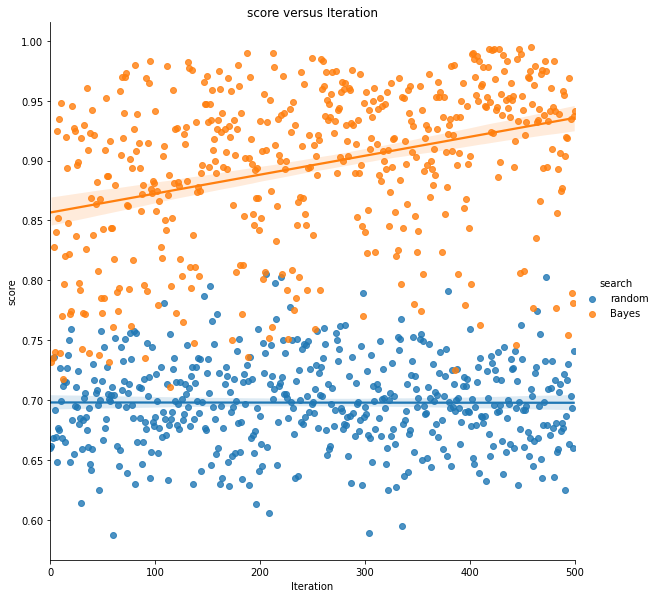

In [103]:
sns.lmplot(x = 'iteration', y = 'score', hue = 'search', data = scores, height = 8);
plt.xlabel('Iteration')
plt.ylabel('score')
plt.title("score versus Iteration");